In [2]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from primary_model import primary_model
from secondary_model import secondary_model
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

Load and Process data

In [3]:
datalist = []
min_rows = float('inf') 

for filename in sorted(os.listdir("/home/yichuan/ywc/meta-labeling/cryptocurrency")):
    if filename.endswith('.csv'):
        file_path = os.path.join("/home/yichuan/ywc/meta-labeling/cryptocurrency", filename)
        print(filename)
        df = pd.read_csv(file_path)
        df = df.drop(columns=["Date"])
        datalist.append(df.values)
        min_rows = min(min_rows, df.shape[0])      

data_list = [data[-min_rows:] for data in datalist]

print(min_rows,len(data_list))

def logVolume(X: np.ndarray):
    volume = X[:, -2]  
    volume_log = np.log(volume + 1)  

    mean_log = np.mean(volume_log)  
    std_log = np.std(volume_log)  

    if std_log == 0:
        volume_std = np.zeros_like(volume_log)  
    else:
        volume_std = (volume_log - mean_log) / std_log  

    X[:, -2] = volume_std  

    return X


for i in range(len(data_list)):
    data_list[i] = logVolume(data_list[i].copy())    

print(data_list[0])

BTC-USD_historical_data.csv
ETH-USD_historical_data.csv
LTC-USD_historical_data.csv
XRP-USD_historical_data.csv
1878 4
[[ 7.44683008e+03  7.44683008e+03  7.10152002e+03 ...  7.14358008e+03
  -2.14055785e+00  2.37206620e+04]
 [ 7.17372998e+03  7.31200000e+03  6.43687012e+03 ...  6.61814014e+03
  -1.56919547e+00  2.62935571e+05]
 [ 6.61860986e+03  6.87314990e+03  6.20422021e+03 ...  6.35760010e+03
  -1.63986817e+00  1.97762388e+05]
 ...
 [ 1.67164004e+04  1.67681699e+04  1.64975566e+04 ...  1.65525723e+04
  -1.57495316e-01  2.61911570e+04]
 [ 1.65523223e+04  1.66517559e+04  1.65086836e+04 ...  1.66423418e+04
  -3.49949060e-01  7.09603865e+03]
 [ 1.66413301e+04  1.66434277e+04  1.64084746e+04 ...  1.66025859e+04
  -2.35515844e-01  2.74453627e+04]]


Generate labels with triple barrier

In [4]:
def calculate_volatility(price_series, lookback_window=20):
    """
    Calculates historical volatility (e.g., standard deviation of log returns).
    This is a placeholder; you might use more sophisticated methods.
    """
    log_returns = np.log(price_series / np.roll(price_series, 1))
    if len(log_returns) < lookback_window:
        return np.full_like(price_series, 0.01) # Default volatility if not enough data
    volatility = pd.Series(log_returns).rolling(window=lookback_window).std().bfill().values
    return np.maximum(volatility, 0.001) # Ensure non-zero volatility


def triple_barrier(close: np.ndarray, days=10, initial_ptsl_factors=[1.5, 1.5], return_min=0.005, use_dynamic_ptsl=True, lookback_volatility=20): # [cite: 3]
    """
    Creates labels based on the triple barrier method.
    - initial_ptsl_factors: Multipliers for volatility to set profit-take/stop-loss.
    - return_min: Minimum return to consider for a +1 or -1 label, if not using dynamic.
    - use_dynamic_ptsl: If True, ptsl levels are based on volatility.
    """
    bin_labels = np.zeros(close.size, dtype=int)
    daily_volatility = calculate_volatility(close, lookback_window=lookback_volatility)

    for i in range(close.size):
        if use_dynamic_ptsl:
            pt_level = close[i] * (1 + daily_volatility[i] * initial_ptsl_factors[0])
            sl_level = close[i] * (1 - daily_volatility[i] * initial_ptsl_factors[1])
        else:
            # Original static ptsl logic can be used if desired, or incorporate return_min
            pt_level = close[i] * (1 + 0.05)
            sl_level = close[i] * (1 - 0.05)


        for d in range(days): 
            index = min(i + d + 1, close.size - 1) 

            # Profit Take
            if close[index] >= pt_level:
                # Ensure minimum return if not dynamic or if pt_level itself doesn't guarantee it
                if not use_dynamic_ptsl and (close[index] / close[i] - 1) < return_min :
                    bin_labels[i] = 0 # Not enough return
                else:
                    bin_labels[i] = 1
                break
            # Stop Loss
            elif close[index] <= sl_level:
                # Ensure minimum return (loss) if not dynamic
                if not use_dynamic_ptsl and (close[i] / close[index] - 1) < return_min: # checks if loss is significant enough
                     bin_labels[i] = 0
                else:
                    bin_labels[i] = -1
                break
            # If neither barrier is hit by the end of `days`, label remains 0 (timeout)
    return bin_labels

binmat=np.full((min_rows, len(data_list)), 0.0)
for i in range(len(data_list)):
    # TODO: Optimize `days`, `initial_ptsl_factors`, `return_min`, `lookback_volatility`
    binmat[:,i]=triple_barrier(data_list[i][:,3], days=10, initial_ptsl_factors=[1.5,1.5], return_min=0.005, use_dynamic_ptsl=True)
pd.DataFrame(binmat).to_csv('/home/yichuan/ywc/meta-labeling/binmat.csv', index=False)
print("binmat 前三列唯一值：", [np.unique(binmat[:,i]) for i in range(3)])

binmat 前三列唯一值： [array([-1.,  0.,  1.]), array([-1.,  0.,  1.]), array([-1.,  0.,  1.])]


Generate Continuous Signal

In [5]:
# TODO: Optimize lmbda and alpha via cross-validation
lmbda = 0.5
alpha = 0.5
label_mat=np.full((min_rows, len(data_list)), 0.0)
lag = 20
def create_lagged_features(data, current_idx, lag=20):
    # data: shape (min_rows, num_features)
        
    X_train, X_test = [], []
    for idx in range(lag, current_idx):
        X_train.append(data[idx-lag:idx].flatten())
    if current_idx >= lag:
        X_test = data[current_idx-lag:current_idx].flatten().reshape(1, -1)
    else:
        X_test = np.zeros((1, lag * data.shape[1]))
    return np.array(X_train), X_test



label_mat_path = '/home/yichuan/ywc/meta-labeling/label_mat.csv'
if os.path.exists(label_mat_path):
    label_mat = pd.read_csv(label_mat_path).values
    print('已从label_mat.csv读取label_mat，跳过生成过程')
else:
    for j in range(len(data_list)):
        y_sm = np.full(min_rows, 0.0)
        y_so = np.full(min_rows, 0.0)

        for i in range(min_rows):
            if i == 0:
                y_sm[i] = binmat[i, j]
            else:
                y_sm[i] = lmbda*binmat[i,j] + (1-lmbda)*y_sm[i-1]
        #print("smooth:",y_sm)
        
        temp_data = data_list[j]
        num_features = temp_data.shape[1]
        for i in range(min_rows):
            if i < 1: 
                y_so[i] = 0 
                continue

            
            
            if i > lag:
                # Placeholder: For simplicity, we'll assume y_so is generated appropriately.
                # Example: train on a rolling window or an expanding window up to i-1
                # For this example, let's use a fixed portion of the early data, which isn't ideal for time series
                # A proper implementation would involve careful time-series cross-validation or walk-forward for this sub-model
            
                # Simplified: Use features from t-1 to predict label at t
                # This part needs careful design to avoid lookahead bias for y_so generation.
                # The original code's direct use of data_list[j][i,:] for x_test might leak info if not handled carefully with lags.
            
                # Placeholder: For simplicity, we'll assume y_so is generated appropriately.
                # In a real scenario, this logistic regression would need its own features (e.g., lagged returns, volatility).

                # Create lagged features
                X_train_loo, X_test_loo = create_lagged_features(temp_data, i, lag=lag)
                y_train_loo_for_lr = binmat[lag:i, j]
                if len(np.unique(y_train_loo_for_lr)) < 2:
                    y_so[i] = y_sm[i-1] if i > 0 else 0
                    continue

                scaler = StandardScaler()   
                X_train_scaled_loo = scaler.fit_transform(X_train_loo)
                x_test_scaled_loo = scaler.transform(X_test_loo)
                model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
                model_lr.fit(X_train_scaled_loo, y_train_loo_for_lr)

                prob = model_lr.predict_proba(x_test_scaled_loo)
                class_labels = model_lr.classes_
                y_so[i] = np.sum(class_labels * prob[0])
            else:
                y_so[i] = y_sm[i-1] if i > 0 else 0
            

        label_mat[:,j] = alpha*y_sm + (1-alpha)*y_so
        #print("soft:",y_so)
    
    label_mat = (label_mat+1)/2
    print("Label mat(targets for primary model):",label_mat)
    pd.DataFrame(label_mat).to_csv('/home/yichuan/ywc/meta-labeling/label_mat.csv', index=False)



# 确保所有二维数组具有相同的形状
shapes = {data.shape for data in data_list}
if len(shapes) > 1:
    raise ValueError("所有 CSV 文件中的数据形状必须一致")
    
dataset=np.array(data_list)
print(dataset.shape)
dataset = dataset.transpose(1, 0, 2).reshape(1878, -1)
print(dataset.shape)

已从label_mat.csv读取label_mat，跳过生成过程
(4, 1878, 7)
(1878, 28)


Training Process

In [6]:
train_ratio = 0.8
num_assets = len(data_list)
n_total_overall = data_list[0].shape[0] # Assuming all have min_rows
n_train_overall = int(n_total_overall * train_ratio)
n_test_overall = n_total_overall - n_train_overall

# Store results
all_primary_signals_test = np.zeros((n_test_overall, num_assets)) 
all_refined_signals_test = np.zeros((n_test_overall, num_assets)) 
primary_model_targets_for_meta = np.zeros((n_test_overall, num_assets)) # To store y_test_pm for each asset

# TODO: Hyperparameter tuning for XGBoost (e.g., using GridSearchCV on X_train_pm_scaled, y_train_pm)
params = {
    "objective": "reg:squarederror", 
    "eval_metric": "rmse", 
    "alpha": 0.1  # L1 reg
    # "tree_method": "hist" # Faster for large datasets
}

param_grid = {
'learning_rate': [0.01,0.1],
'max_depth': [3, 4, 5, 6],
'n_estimators': [100, 200, 300],
'subsample': [0.5, 0.75, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0]
}
best_primary_params_per_asset = {}

# Check and load saved best params
primary_params_file = 'best_primary_model_params.json'
loaded_best_primary_params = None

if os.path.exists(primary_params_file):
    with open(primary_params_file, 'r') as f:
        loaded_best_primary_params = json.load(f)
    print(f"已从 {primary_params_file} 加载一级模型最佳参数，跳过调参。")
else:
    print(f"未找到 {primary_params_file}，将进行一级模型调参。")

for i in range(num_assets):
    print(f"Processing Asset {i}...")
    """# Generate continuous labels (targets for primary model) for this asset
    # Example: Re-generating simple binmat and y_sm for target
    current_binmat = triple_barrier(data_list[i][:, 3], days=10, use_dynamic_ptsl=True)
    y_sm_temp = np.zeros(min_rows)
    for k_idx in range(min_rows):
        if k_idx == 0: y_sm_temp[k_idx] = current_binmat[k_idx]
        else: y_sm_temp[k_idx] = 0.5 * current_binmat[k_idx] + (1 - 0.5) * y_sm_temp[k_idx-1]
    current_continuous_labels = (y_sm_temp + 1) / 2 # Target for primary model"""

    pre_tuned_params_for_current_asset = loaded_best_primary_params.get(f'asset_{i}') if loaded_best_primary_params else None
    primary_preds_test, scaler_for_asset, model_pm, newly_tuned_params = primary_model(
        asset_idx=i,
        full_asset_data=data_list[i], # Pass all features for this asset 
        continuous_labels_for_asset=label_mat[:,i],
        train_ratio=train_ratio,
        params=params,
        param_grid=param_grid,
        pre_tuned_params=pre_tuned_params_for_current_asset
    )
    all_primary_signals_test[:, i] = primary_preds_test

    primary_model_targets_for_meta[:, i] = label_mat[:,i][n_train_overall:]
    X_test_features_pm = data_list[i][n_train_overall:]
    X_test_features_pm_scaled = scaler_for_asset.transform(X_test_features_pm)

    
    if newly_tuned_params:
        best_primary_params_per_asset[f'asset_{i}'] = newly_tuned_params
    elif pre_tuned_params_for_current_asset: 
        best_primary_params_per_asset[f'asset_{i}'] = pre_tuned_params_for_current_asset

    refined_s = secondary_model(
        asset_idx=i,
        X_test_features_from_primary=X_test_features_pm, # Pass unscaled or scaled based on NN's needs
        primary_model_targets_on_test_set=primary_model_targets_for_meta[:, i],
        primary_model_predictions_on_test_set=primary_preds_test,
        primary_signals_to_refine=primary_preds_test,
        nn_input_dim=data_list[i].shape[1] # Original feature dim, will be +1 in function 
    )
    all_refined_signals_test[:, i] = refined_s

if not loaded_best_primary_params or best_primary_params_per_asset:
    with open(primary_params_file, 'w') as f:
        json.dump(best_primary_params_per_asset, f, indent=4)
    print(f"\n最佳一级模型参数已保存到 {primary_params_file}")

print("primary_signals(test set head)", all_primary_signals_test[:5])
print("Refined_signals(test set head)", all_refined_signals_test[:5])
print(f"\nFinal Best Primary Model Parameters (from file or tuning): {best_primary_params_per_asset}")

已从 best_primary_model_params.json 加载一级模型最佳参数，跳过调参。
Processing Asset 0...


测试集均方误差： 0.038694988924190536

Asset 0, NN Final Test Loss (predicting error): 0.0266
Asset 0: Number of signals refined by meta-model: 340

Processing Asset 1...
测试集均方误差： 0.03964676177577611

Asset 1, NN Final Test Loss (predicting error): 0.0220
Asset 1: Number of signals refined by meta-model: 118

Processing Asset 2...
测试集均方误差： 0.038339551546527274

Asset 2, NN Final Test Loss (predicting error): 0.0371
Asset 2: Number of signals refined by meta-model: 65

Processing Asset 3...
测试集均方误差： 0.03171800037950503

Asset 3, NN Final Test Loss (predicting error): 0.0811
Asset 3: Number of signals refined by meta-model: 74


最佳一级模型参数已保存到 best_primary_model_params.json
primary_signals(test set head) [[0.56812733 0.52878642 0.54418623 0.44952404]
 [0.54170138 0.5314247  0.54120272 0.44814447]
 [0.54170138 0.53955096 0.51087767 0.44352698]
 [0.54170138 0.53467023 0.51276028 0.44559973]
 [0.54170138 0.54079145 0.4681057  0.44421583]]
Refined_signals(test set head) [[0.64880133 0.6706599  0.69562

In [7]:
not_equal = all_primary_signals_test != all_refined_signals_test
refined_num_per_asset = np.sum(not_equal, axis=0)
print("Number of refined signals per asset:", refined_num_per_asset)

error1 = (all_primary_signals_test < 0) | (all_primary_signals_test > 1)
error2 = (all_refined_signals_test < 0) | (all_refined_signals_test > 1)
print("errors:",np.sum(error1),np.sum(error2))

Number of refined signals per asset: [340 118  65  74]
errors: 0 0


Generate modified(final) portfolio 

In [8]:
# Assume asset returns, sector mapping, and covariance matrix as placeholders
Closemat_all = np.zeros((min_rows, num_assets))
for i in range(num_assets):
    Closemat_all[:,i] = data_list[i][:,3]
sector_mapping = np.array([1,2,3,4])

Close_train_pm = Closemat_all[:n_train_overall, :]
returns_train_pm = np.log(Close_train_pm[1:] / Close_train_pm[:-1])
if np.any(np.isinf(returns_train_pm)) or np.any(np.isnan(returns_train_pm)):
    returns_train_pm = np.nan_to_num(returns_train_pm, nan=0.0, posinf=0.0, neginf=0.0)

# Robust covariance estimation is recommended here (e.g., shrinkage)
cov_matrix_train_pm = np.cov(returns_train_pm, rowvar=False) # [cite: 10]
# Make sure cov_matrix is not singular or ill-conditioned. Add regularization if needed.
cov_matrix_train_pm = cov_matrix_train_pm + np.eye(cov_matrix_train_pm.shape[0]) * 1e-6  # Small regularization

In [9]:
def apply_constraints(weights, sector_mapping, cov_matrix, max_exposure=0.4, min_sectors=2, max_risk=0.01):
    # Original constraints logic
    def asset_exposure_constraint(weights, max_exposure): return all(abs(w) <= max_exposure for w in weights)
    def sector_diversification_constraint(weights, sector_mapping, min_sectors):
        if np.all(weights == 0): return len(np.unique(sector_mapping)) >= min_sectors # Or specific handling
        active_sectors = sector_mapping[np.nonzero(weights)[0]] # Get sectors for assets with non-zero weights
        return len(np.unique(active_sectors)) >= min_sectors
    def risk_tolerance_constraint(weights, cov_matrix, max_risk):
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        return portfolio_variance <= max_risk
    
    if not (sector_mapping.shape[0] == cov_matrix.shape[0] == len(weights)):
        # print(f"Shape mismatch: sectors {sector_mapping.shape}, cov {cov_matrix.shape}, weights {len(weights)}")
        return False # Or raise error

    return (asset_exposure_constraint(weights, max_exposure) and
            sector_diversification_constraint(weights, sector_mapping, min_sectors) and
            risk_tolerance_constraint(weights, cov_matrix, max_risk))

In [10]:
def construct_portfolio(signals_matrix, cov_matrix_for_constraints, sector_mapping_for_constraints):
    weights = signals_matrix.copy()
    # Normalize signals to sum to 1 (assuming long-only, fully invested from positive signals)
    row_sums = weights.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1e-6 
    weights = weights / row_sums
    constraint_violations_count = 0
    for i in range(len(weights)):
        if i == 0: 
            if not apply_constraints(weights[i, :], sector_mapping_for_constraints, cov_matrix_for_constraints):
              # Fallback for first day: e.g., 1/N or skip trading
                weights[i, :] = np.ones(weights.shape[1]) / weights.shape[1] 
                constraint_violations_count +=1
        elif not apply_constraints(weights[i, :], sector_mapping_for_constraints, cov_matrix_for_constraints):
            weights[i, :] = weights[i-1, :] # Carry forward previous day's weights
            constraint_violations_count += 1
    print(f"Number of days constraints caused reversion to previous weights: {constraint_violations_count}")
    return weights

In [11]:
sector_map = np.array([1,2,3,4])
final_portfolio_weights_refined = construct_portfolio(all_refined_signals_test, cov_matrix_train_pm, sector_map) 
final_portfolio_weights_primary = construct_portfolio(all_primary_signals_test, cov_matrix_train_pm, sector_map) 
print(final_portfolio_weights_refined)

Number of days constraints caused reversion to previous weights: 1
Number of days constraints caused reversion to previous weights: 0
[[0.26891405 0.27797395 0.28832271 0.16478929]
 [0.25430676 0.28978171 0.27261938 0.18329215]
 [0.25322611 0.2984417  0.2669157  0.18141648]
 ...
 [0.24346877 0.28583304 0.25024096 0.22045724]
 [0.22404108 0.28901746 0.25845877 0.22848269]
 [0.24437852 0.28275391 0.25168211 0.22118547]]


Evaluate the performance of the portfolio

In [15]:
folder_path_sharpe = "/home/yichuan/ywc/meta-labeling/cryptocurrency"
m_sharpe = n_train_overall +1 # Data for test period
n_sharpe = n_test_overall

def evaluate_metrics(folder_path, portfolio_weights_ts, m, n,risk_free_rate=0.0):
    
    files = sorted(os.listdir(folder_path))    
    stock_data_close = []
    
    for file in files:
        if file.endswith('.csv'):
            df_sharpe = pd.read_csv(os.path.join(folder_path, file)).iloc[-n:,:]
            stock_data_close.append(df_sharpe['Close'].values)
    
    stock_prices_eval = np.column_stack(stock_data_close)

    print(stock_prices_eval.shape, portfolio_weights_ts.shape)
    worth = np.sum(stock_prices_eval * portfolio_weights_ts, axis=1)
    peak = np.maximum.accumulate(worth)
    drawdown = (peak - worth) / peak
    maxdrawdown = drawdown.max()
    

    stock_returns_eval = np.diff(stock_prices_eval, axis=0) / stock_prices_eval[:-1, :]
    stock_returns_eval = np.nan_to_num(stock_returns_eval, nan=0.0)

    # Ensure weights match the number of return periods
    if portfolio_weights_ts.shape[0] != stock_returns_eval.shape[0]:
        print(f"Warning: Sharpe calculation weight rows ({portfolio_weights_ts.shape[0]}) != return rows ({stock_returns_eval.shape[0]}). Trimming weights.")
        # This can happen if weights are for T days, returns for T-1 days. Align.
        # Typically, weights at start of day t (W_t) apply to returns from t to t+1 (R_t+1)
        # So, use weights[:-1] if it has one extra day.
        min_len = min(portfolio_weights_ts.shape[0], stock_returns_eval.shape[0])
        current_weights = portfolio_weights_ts[:min_len,:]
        current_returns = stock_returns_eval[:min_len,:]
    else:
        current_weights = portfolio_weights_ts
        current_returns = stock_returns_eval  

    portfolio_daily_returns = np.sum(current_returns * current_weights, axis=1)
    if len(portfolio_daily_returns) == 0: return 0.0
    
    mean_return_daily = np.mean(portfolio_daily_returns)
    print(mean_return_daily)
    
    volatility_daily = np.std(portfolio_daily_returns)
    if volatility_daily == 0: return 0.0

    annualization_factor = 365
    mean_return_annual = mean_return_daily * annualization_factor
    volatility_annual = volatility_daily * np.sqrt(annualization_factor)
    print(volatility_annual)
    if volatility_annual == 0: return 0.0
  
    sharpe = (mean_return_annual - risk_free_rate) / volatility_annual

    weight_diffs = np.diff(current_weights, axis=0)
    daily_turnover = np.sum(np.abs(weight_diffs), axis=1) / 2
    annual_turnover = np.mean(daily_turnover) * annualization_factor
    calmar = mean_return_annual / abs(maxdrawdown)
    return sharpe, maxdrawdown, calmar, annual_turnover



"""sharpe_ratio_refined = evaluate_metrics(folder_path_sharpe, final_portfolio_weights_refined, m_sharpe, n_sharpe)
print(f"Sharpe Ratio of the REFINED weights: {sharpe_ratio_refined:.4f}")
sharpe_ratio_primary_revised = evaluate_metrics(folder_path_sharpe, final_portfolio_weights_primary, m_sharpe, n_sharpe)
print(f"Sharpe Ratio of the PRIMARY portfolio: {sharpe_ratio_primary_revised:.4f}")
OneN_weights = np.ones_like(final_portfolio_weights_primary) * (1/num_assets)
sharpe_ratio_1_N = evaluate_metrics(folder_path_sharpe, OneN_weights, m_sharpe, n_sharpe)
print(f"Sharpe Ratio of the 1/N portfolio: {sharpe_ratio_1_N:.4f}")"""

OneN_weights = np.ones_like(final_portfolio_weights_primary) * (1/num_assets)
inputs = [final_portfolio_weights_refined, final_portfolio_weights_primary, OneN_weights]
input_name = ["refined weights", "primary weights", "OneN weights"]
results = []
for i, input_val in enumerate(inputs):
    # 调用函数获取四个输出
    out1, out2, out3, out4 = evaluate_metrics(folder_path_sharpe, input_val, m_sharpe, n_sharpe)
    
    # 将结果添加到列表
    results.append({
        "输入值": input_name[i],
        "Sharpe Ratio": out1,
        "Max Drawdown": out2,
        "Calmar": out3,
        "Annual Turnover": out4
    })

# 创建DataFrame表格
df = pd.DataFrame(results)

# 打印表格
print("\n函数输出结果统计表:")
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=True))

(376, 4) (376, 4)
-0.0018356597715215638
0.7274328167180252
(376, 4) (376, 4)
-0.001780691329536675
0.732126156345512
(376, 4) (376, 4)
-0.0017536464540885489
0.7322687715530671

函数输出结果统计表:
+---+-----------------+---------------------+--------------------+---------------------+--------------------+
|   |     输入值      |    Sharpe Ratio     |    Max Drawdown    |       Calmar        |  Annual Turnover   |
+---+-----------------+---------------------+--------------------+---------------------+--------------------+
| 0 | refined weights | -0.9210689993727477 | 0.7263977982709426 | -0.9223813979065205 | 8.118468141078987  |
| 1 | primary weights | -0.8877600255742736 | 0.7290449641650205 | -0.8915120016298043 | 3.6682954725536603 |
| 2 |  OneN weights   | -0.8741065857345988 | 0.6920032643279528 | -0.924968116102664  |        0.0         |
+---+-----------------+---------------------+--------------------+---------------------+--------------------+


股票相关系数矩阵:
[[1.   0.79 0.76 0.56]
 [0.79 1.   0.82 0.65]
 [0.76 0.82 1.   0.64]
 [0.56 0.65 0.64 1.  ]]


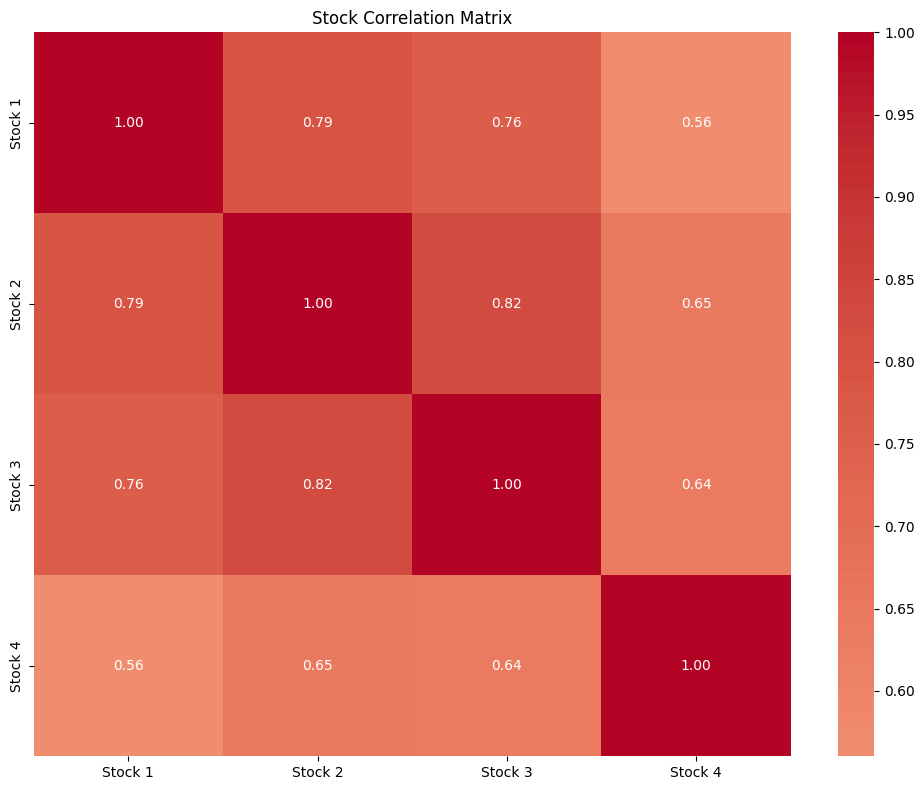


最高正相关: 股票1 和 股票2, 相关系数 = 0.8201
最高负相关: 股票0 和 股票3, 相关系数 = 0.5603


In [13]:


# 假设 price_matrix 是一个形状为 (days, n_stocks) 的 NumPy 矩阵
# 示例数据：5只股票60天的价格
price_matrix = Closemat_all

# 1. 计算对数收益率 (更符合金融数据特性)
# 使用向量化操作提高效率
returns = np.diff(np.log(price_matrix), axis=0)

# 2. 计算相关系数矩阵 (使用NumPy的corrcoef函数)
# 注意：corrcoef默认每行是一个变量，所以需要转置
corr_matrix = np.corrcoef(returns.T)

# 3. 打印结果
print("股票相关系数矩阵:")
print(np.around(corr_matrix, 2))

# 4. 可视化 (可选)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            center=0,
            xticklabels=[f'Stock {i+1}' for i in range(price_matrix.shape[1])],
            yticklabels=[f'Stock {i+1}' for i in range(price_matrix.shape[1])])
plt.title('Stock Correlation Matrix')
plt.tight_layout()
plt.show()


# 6. 找出相关性最高的股票对 (可选)
n = corr_matrix.shape[0]
# 创建掩码矩阵排除对角线
mask = np.ones_like(corr_matrix, dtype=bool)
np.fill_diagonal(mask, False)

# 找出最高正相关
max_corr = corr_matrix[mask].max()
max_indices = np.where(corr_matrix == max_corr)
print(f"\n最高正相关: 股票{max_indices[0][0]} 和 股票{max_indices[1][0]}, 相关系数 = {max_corr:.4f}")

# 找出最高负相关
min_corr = corr_matrix[mask].min()
min_indices = np.where(corr_matrix == min_corr)
print(f"最高负相关: 股票{min_indices[0][0]} 和 股票{min_indices[1][0]}, 相关系数 = {min_corr:.4f}")

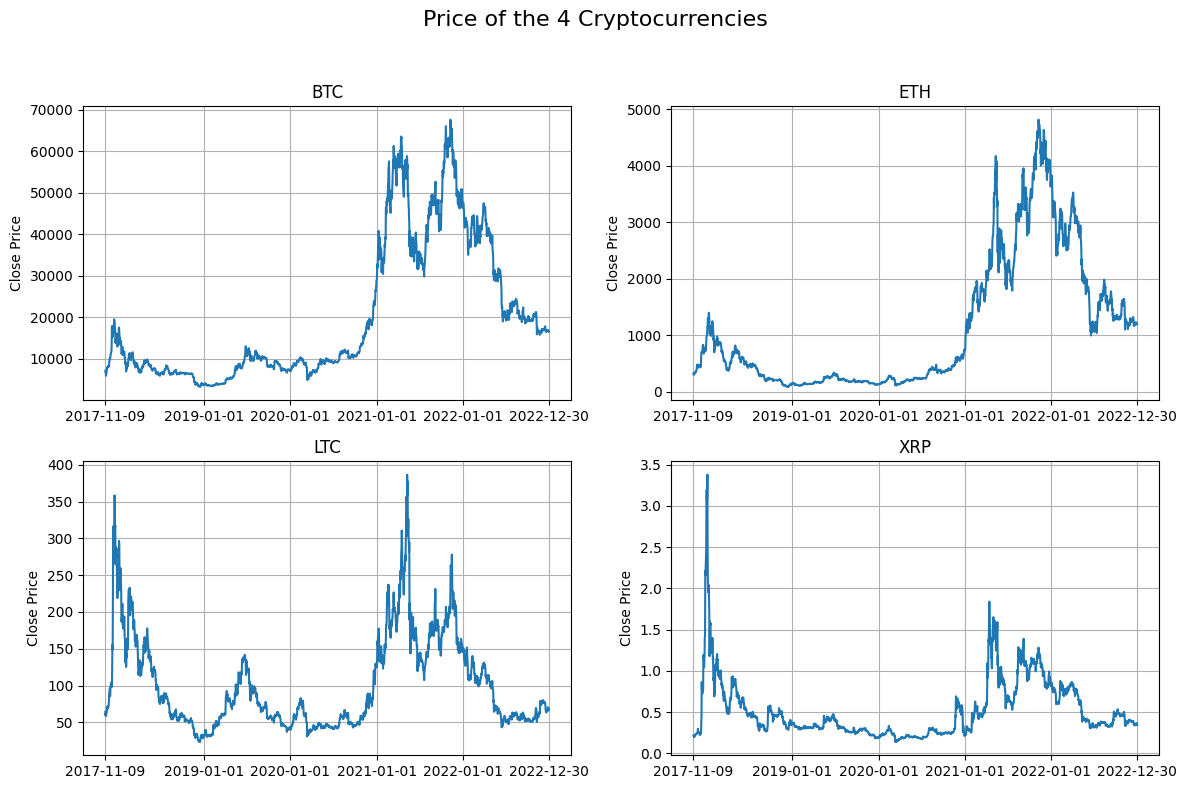

In [ ]:
y=[]
for i in range(4):
    y.append(data_list[i][:,3])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
start_date = np.datetime64('2017-11-09')
dates = start_date + np.arange(len(y[0]))
name=["BTC","ETH","LTC","XRP"]
for i, ax in enumerate(axs.flat):
    ax.plot(dates, y[i])
    ax.set_title(name[i])
    ax.set_ylabel('Close Price')
    ax.grid(True)
    mid1 = np.datetime64('2019-01-01')
    mid2 = np.datetime64('2020-01-01')
    mid3 = np.datetime64('2021-01-01')
    mid4 = np.datetime64('2022-01-01')
    ax.set_xticks([dates[0], mid1, mid2, mid3, mid4, dates[-1]])
    ax.set_xticklabels([str(dates[0]), str(mid1), str(mid2), str(mid3), str(mid4),str(dates[-1])], rotation=0)

fig.suptitle('Price of the 4 Cryptocurrencies', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## TODO:
 1. Implement robust hyperparameter tuning for all models and parameters (e.g., using time-series cross-validation like KFold with shuffle=False, or specialized time-series splits).
 2. Implement walk-forward validation for a more realistic backtest.
 3. Add more evaluation metrics (Sortino, Max Drawdown, Calmar, Turnover).
 4. Conduct statistical significance testing for Sharpe Ratios (e.g., Ledoit-Wolf test for Sharpe differences or bootstrapping).
 5. Further refine feature engineering for both primary and secondary models.
 6. For `y_so` in continuous signal generation, ensure a proper non-lookahead model is built.
 7. Ensure all data scaling (StandardScaler) is fit only on training data and transformed on validation/test data.
 8. The NN architecture, optimizers, and loss functions should be carefully tuned.
 9. Review all array indexing, especially around train/test splits and lags, to prevent off-by-one errors or data leakage.